# Import Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPool1D, Input, LSTM, Bidirectional, Layer, Dot, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.dtypes import uint8, float32
import pickle

In [2]:
from tensorflow.random import set_seed
set_seed(5)

# Model 2

In [6]:
path = os.getcwd() + '/'
x_train=pickle.load(open(path+'x_train.pkl', 'rb'))
y_train=pickle.load(open(path+'y_train.pkl', 'rb'))
y_test=pickle.load(open(path+'y_test.pkl', 'rb'))
x_test=pickle.load(open(path+'x_test.pkl', 'rb'))
x_val=pickle.load(open(path+'x_val.pkl', 'rb'))
y_val=pickle.load(open(path+'y_val.pkl', 'rb'))
embedding_layer = pickle.load(open(path+'i100embedding_layer.pkl', 'rb'))

In [4]:
class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(1,), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        if not self.return_sequences:
            output = tf.keras.backend.sum(output, axis=1)
        return output

In [5]:
class myCallback(Callback):
    def __init__(self, model_name='CNN_BiLSTM_ATT', model_dir='./Models/CNN_BLSTM_ATT_Models'):
        super(myCallback, self).__init__()
        self.model_name = model_name
        self.model_dir = model_dir
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)
        # You can add logging or other actions at the end of each epoch if needed

    def on_train_end(self, logs=None):
        if logs is None:
            logs = {}

        # Save model in .h5 format
        h5_model_path = os.path.join(self.model_dir, f"{self.model_name}.h5")
        self.model.save(h5_model_path)
        print(f"Model saved at: {h5_model_path} (H5 format)")

In [6]:
# Model Definition
i = Input([100], dtype=tf.uint8)
x = embedding_layer(i)
x = Conv1D(128, 5, activation='relu')(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)
x = MaxPool1D()(x)

rnn_cell_size = 128

x = Bidirectional(LSTM(rnn_cell_size, return_sequences=True), name="bi_lstm_0")(x)
x = Dropout(0.30)(x)
x = Attention(return_sequences=False)(x) 

# Final dense layer for binary classification
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[i], outputs=output, name='CNN+BiLSTM+ATT')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()
callback = myCallback(model_name='CNN_BiLSTM_ATT', model_dir='./Models/CNN_BLSTM_ATT_Models')

Model: "CNN+BiLSTM+ATT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 300)            │      38,994,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 128)             │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bi_lstm_0 (Bidirectional)            │ (None, 48, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 256)                 │             257 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,451,222 (150.49 MB)

 Trainable params: 39,450,966 (150.49 MB)

 Non-trainable params: 256 (1.00 KB)

## How Attention Works

1. **Step 1**: The BiLSTM processes the input sequence and outputs hidden states for each step.
  
2. **Step 2**: The attention layer assigns a score to each step, showing its importance.
  
3. **Step 3**: The attention layer uses these scores to create a single vector that captures the most important parts of the sequence.
  
4. **Step 4**: This vector is passed to the final layer, which uses it to make the prediction.

When trying to classify a sentence as positive or negative. Some words or phrases, like "love" or "hate," may be more important for understanding the sentiment. The attention layer helps the model pay attention to these key words, making the prediction more accurate.d interpretable prediction.


In [8]:
BATCH_SIZE = 64
EPOCHS = 30

TRAINING_STEPS = len(x_train) // BATCH_SIZE
VALIDATION_STEPS = len(x_val) // BATCH_SIZE

history = model.fit(x_train, y_train,
                    steps_per_epoch=TRAINING_STEPS,
                    validation_data=(x_val, y_val),
                    validation_steps=VALIDATION_STEPS,
                    epochs=EPOCHS,
                    callbacks=[callback],
                    verbose='auto')

pickle.dump(history.history, open('./Models/CNN_BLSTM_ATT_Models/history_CNN_BiLSTM_ATT.pkl', 'wb'))

Epoch 1/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 141s 252ms/step - accuracy: 0.9563 - loss: 0.1172 - val_accuracy: 0.9468 - val_loss: 0.1325
Epoch 2/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 137s 244ms/step - accuracy: 0.9673 - loss: 0.0845
Epoch 3/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 139s 248ms/step - accuracy: 0.9778 - loss: 0.0636 - val_accuracy: 0.9601 - val_loss: 0.1077
Epoch 4/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 139s 248ms/step - accuracy: 0.9830 - loss: 0.0470
Epoch 5/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 141s 250ms/step - accuracy: 0.9857 - loss: 0.0382 - val_accuracy: 0.9648 - val_loss: 0.1005
Epoch 6/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 139s 248ms/step - accuracy: 0.9900 - loss: 0.0297
Epoch 7/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 140s 250ms/step - accuracy: 0.9911 - loss: 0.0256 - val_accuracy: 0.9639 - val_loss: 0.1378
Epoch 8/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 139s 248ms/step - accuracy: 0.9914 - loss: 0.0241
Epoch 9/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 140s 250ms/step - accuracy: 0.9931 - loss: 0.0205 - val_accuracy: 0.9717

Model saved at: ./Models/CNN_BLSTM_ATT_Models\CNN_BiLSTM_ATT.h5 (H5 format)


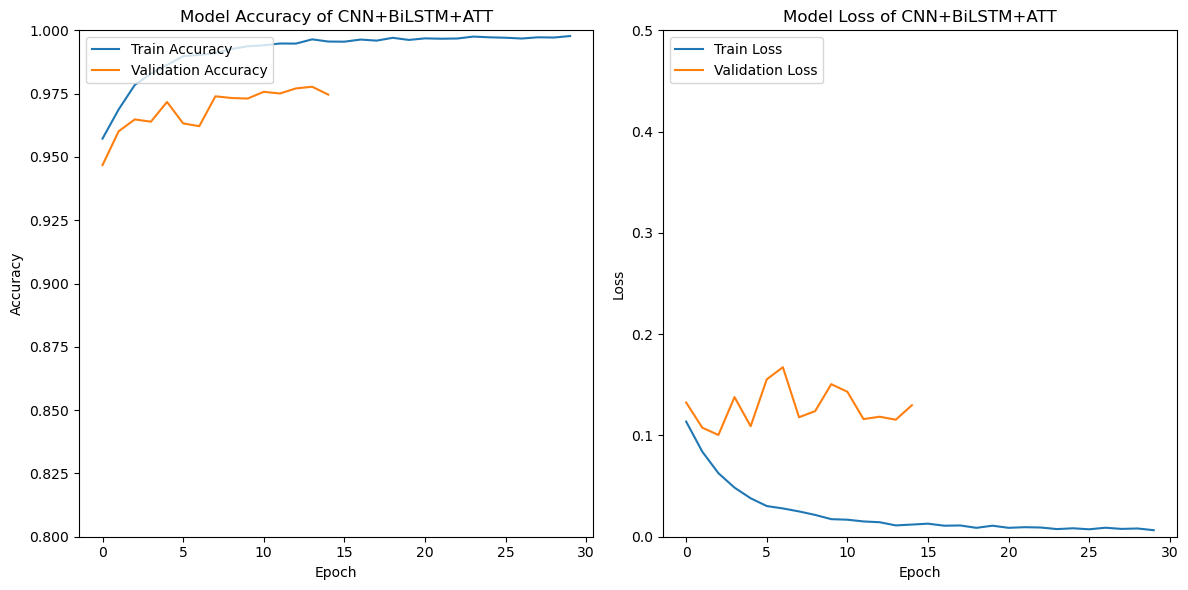

In [3]:
with open('./Models/CNN_BLSTM_ATT_Models/history_CNN_BiLSTM_ATT.pkl', 'rb') as file:
    history = pickle.load(file)
    
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Accuracy
axs[0].plot(history['accuracy'], label='Train Accuracy')
axs[0].plot(history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy of CNN+BiLSTM+ATT')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0.8, 1)
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history['loss'], label='Train Loss')
axs[1].plot(history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss of CNN+BiLSTM+ATT')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(0, 0.5)
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [3]:
from tensorflow.keras import layers 

class Attention(layers.Layer):
    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(1,), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        if not self.return_sequences:
            output = tf.keras.backend.sum(output, axis=1)
        return output


# Register the custom Attention layer
tf.keras.utils.get_custom_objects().update({'Attention': Attention})

saved_model_path = './Models/CNN_BLSTM_ATT_Models\CNN_BiLSTM_ATT.h5'

# Load the model with the custom objects
inference_model = tf.keras.models.load_model(saved_model_path)

In [7]:
y_pred= inference_model.predict(x_test)
y_pred = np.squeeze(y_pred)
y_pred

141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


array([7.5023703e-11, 7.4414239e-09, 1.3547964e-09, ..., 8.3528684e-10,
       2.6303087e-06, 9.9999946e-01], dtype=float32)

In [8]:
p = lambda t : 1 if t>=0.5 else 0
y_pred=np.vectorize(p)(y_pred)

In [9]:
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

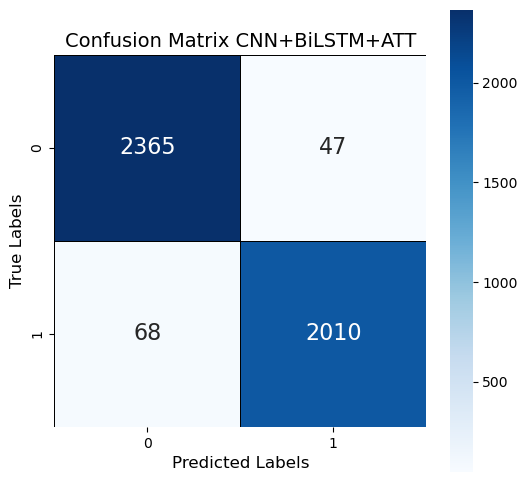

In [16]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black')

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix CNN+BiLSTM+ATT', fontsize=14)
plt.show()


|   | Predicted: True News | Predicted: Fake News |
|---|----------------------|---------------------|
| **Actual: True News**    | 2,365 (TP)          | 47 (FN)             |
| **Actual: Fake News**    | 68 (FP)            | 2,010 (TN)           |

In [17]:
# Displaying performance metrics
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Accuracy: 0.974
Precision: 0.977
Recall: 0.967
F1 Score: 0.972


- These results indicate that the model performs very well.
- It achieves better results than Model 1 (CNN+LSTM) with the following metrics:
    - **Accuracy**: 0.943
    - **Precision**: 0.964
    - **Recall**: 0.910
    - **F1 Score**: 0.936

In [23]:
dot_img_dir = 'vis'
dot_img_file = os.path.join(dot_img_dir, 'model_2.png')

# Plot and save the model architecture to the specified file
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

print(f"Model architecture saved to: {dot_img_file}")

Model architecture saved to: vis\model_2.png
